In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from time import time
from sympy import Symbol, diff, lambdify, sin, exp



In [3]:
#przedział funkcji
a = -4*math.pi
b = 3*math.pi
#liczba punktów na wykresach i przy obliczaniu błędów
points = 1000

In [4]:
def hermite_interpolation(xs, ys):
    ms = [len(y_values) for y_values in ys]
    m = sum(ms)
    quoteint_difference_tab = [[None for _ in range(m)] for _ in range(m)]

    # lista argumentów z powtórzeniami
    xs_reps = []
    for i in range(len(xs)):
        xs_reps.extend([xs[i]] * ms[i])
    i = 0
    for y_values in ys:
        for j in range(len(y_values)):
            for k in range(j + 1):
                quoteint_difference_tab[i][k] = y_values[k] / factorial(k)
            i += 1
    for j in range(1, m):
        for i in range(j, m):
            if quoteint_difference_tab[i][j] is None:
                quoteint_difference_tab[i][j] = (quoteint_difference_tab[i][j - 1] - quoteint_difference_tab[i - 1][
                    j - 1]) / (xs_reps[i] - xs_reps[i - j])

    factor_tab = [quoteint_difference_tab[i][i] for i in range(m)]

    def f(x_arg):
        result = factor_tab[m - 1]
        for i in range(m - 2, -1, -1):
            result = result * (x_arg - xs_reps[i]) + factor_tab[i]
        return result


    return f

In [5]:
def chebyshev_nodes(a, b, n):
    x = []
    for i in range(1, n + 1):
        x.append(0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * i - 1) / (2 * n) * np.pi))
    return x

In [6]:
def factorial(n): return n * factorial(n - 1) if n > 1 else 1

In [7]:
def calc_derivate(func, n=1):
    x = Symbol('x')
    f = func(x)
    for i in range(1, n + 1):
        f = diff(f, x)

    return lambdify(x, f)


In [46]:
def hermite_interpolation_func(f, a, b, n,derivatives=True, derivate=None, chebyshev=False, ax=None):
    if chebyshev:
        x = chebyshev_nodes(a, b, n)
    else:
        x = np.linspace(a, b, n)
    if derivatives:
        if derivate is not None:
            y = [[f(x[i]), derivate(x[i])] for i in range(n)]
        else:
            derivate = calc_derivate(f, 1)
            y = [[f(x[i]), derivate(x[i])] for i in range(n)]

    else:
        y=[[f(x[i])] for i in range(n)]
    if ax is not None:
        ax.plot(x, [f(x_arg) for x_arg in x], 'o', c="r")
    return hermite_interpolation(x, y)

In [9]:
def data_plot(xs, ys, label=''):
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(xs, ys)
    if label: plt.legend(loc="best")


def func_plot(fn, a, b, n, label='', color='', figsize=(6, 4), subplot=None, title=''):
    if subplot is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = subplot
    xs = np.linspace(a, b, num=n)
    ys = [fn(xi) for xi in xs]
    if color:
        ax.plot(xs, ys, label=label, color=color)
    else:
        ax.plot(xs, ys, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if label:
        ax.legend(loc="best")
    if title:
        ax.set_title(title)


#### 1.5. Tabele

In [10]:
def create_compare_errors_table(hermit_errors):
    data = {"Interpolacja Hermite'a":hermit_errors}
    df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    return df


In [11]:
def max_absolute_error(f, W, xs):
    return max([abs(f(x) - W(x)) for x in xs])


In [12]:
def mse(f, W, xs):
    return sum([(f(x) - W(x)) ** 2 for x in xs]) / len(xs)

#### 1.7. Analiza

In [13]:
from IPython.display import Markdown
def interpolation_analysis(f, a, b, n):
    xs = np.linspace(a,b, points)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    hermit_linespace = hermite_interpolation_func(f,a,b,n, ax=axs[0])
    hermit_chebyshev = hermite_interpolation_func(f,a,b,n, chebyshev=True, ax=axs[1])


    hermit_linespace_errors = [max_absolute_error(f, hermit_linespace ,xs), mse(f,hermit_linespace ,xs)]
    hermit_chebyshev_errors = [max_absolute_error(f,hermit_chebyshev, xs), mse(f,hermit_chebyshev, xs)]

    func_plot(f, a, b, points , label='f', subplot=axs[0], title="Rozkład równomierny")
    func_plot(hermit_linespace, a, b, points , label='Hermit', subplot=axs[0])
    func_plot(f, a, b, points, label='f', subplot=axs[1], title="Węzły chebysheva")
    func_plot(hermit_chebyshev, a, b, points , label='Hermit', subplot=axs[1])
    plt.show()
    display(Markdown("""#### Wartości błędów dla węzłów rozłożonych równomiernie"""))
    display(create_compare_errors_table(hermit_linespace_errors))
    display(Markdown("""#### Wartości błędów dla węzłów Czebyszewa"""))
    display(create_compare_errors_table(hermit_chebyshev_errors))

def display_interpolation(f, a,b,n, interpolation, label,color=None,chebyshev=False, title=""):

    xs = np.linspace(a,b, points)
    fig, ax = plt.subplots(figsize=(6, 4))
    W = interpolation(f,a,b,n,chebyshev=chebyshev, ax=ax)
    W_errors = [max_absolute_error(f, W ,xs), mse(f,W ,xs)]
    func_plot(f, a, b, 1000, label="f(x)", subplot=ax)
    if color is not None:
        func_plot(W, a, b, 1000, label=label, subplot=ax, color=color, title=title)
    else:
        func_plot(W, a, b, 1000, label=label, subplot=ax, title=title)

    plt.show()
    data = {label:W_errors}
    df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    display(df)

#### 1.8. Pomiar czasu

In [14]:
def display_time(sec):
    hours = int(sec // 3600)
    minutes = int((sec % 3600) // 60)
    seconds = int(sec % 60)
    print(f"Czas trwania algorytmu: {hours} godzin {minutes} minut {seconds} sekund")

In [15]:
f = lambda x, k=4, m=1: exp(-k * sin(m * x)) + k * sin(m * x) - 1

#### 2.1. Wykres funkcji $ f(x) $

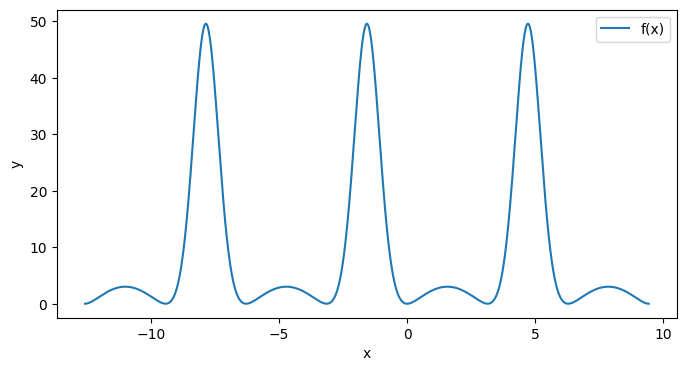

In [16]:
func_plot(f, a, b, 1000, label="f(x)", figsize=(8,4))

#### 2.2. Analiza interpolacji dla różnej ilości węzłów $n$
- $ n = 5 $

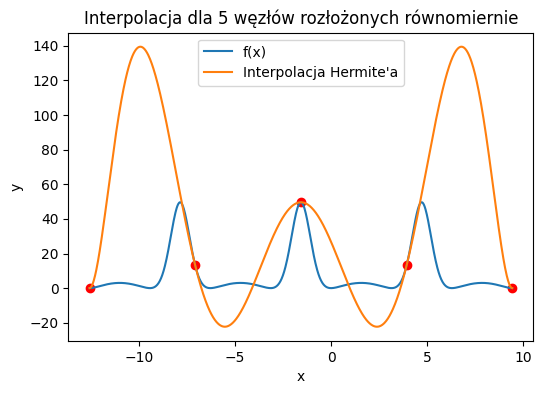

,Interpolacja Hermite'a
Błąd bezwzględny,138.473601185930
Błąd średniokwadratowy,4090.18004483349


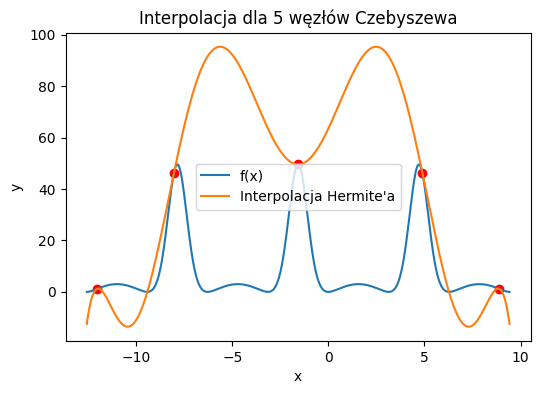

,Interpolacja Hermite'a
Błąd bezwzględny,94.1301888734862
Błąd średniokwadratowy,2872.74750290273


In [17]:

display_interpolation(f,a,b,5, hermite_interpolation_func, label="Interpolacja Hermite'a", title="Interpolacja dla 5 "
                                                                                                 "węzłów rozłożonych "
                                                                                                 "równomiernie" )
display_interpolation(f,a,b,5, hermite_interpolation_func, label="Interpolacja Hermite'a", chebyshev=True,
                      title="Interpolacja dla 5 węzłów Czebyszewa" )


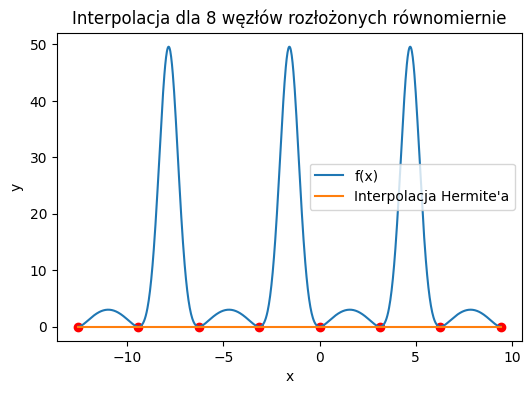

,Interpolacja Hermite'a
Błąd bezwzględny,49.5978850078105
Błąd średniokwadratowy,288.186545308619


In [21]:
n=8
display_interpolation(f,a,b,n, hermite_interpolation_func, label="Interpolacja Hermite'a", title="Interpolacja dla 8 "
                                                                                                 "węzłów rozłożonych "
                                                                                                 "równomiernie" )


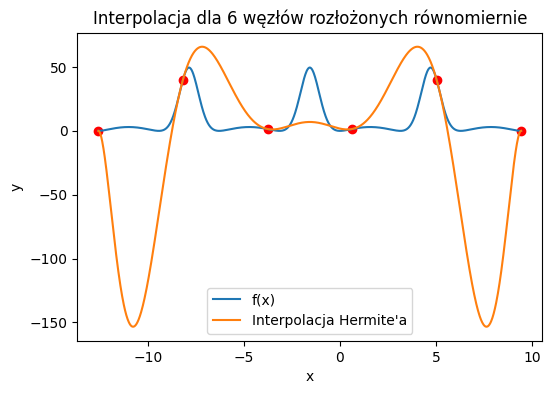

,Interpolacja Hermite'a
Błąd bezwzględny,156.341805478150
Błąd średniokwadratowy,4260.71112579025


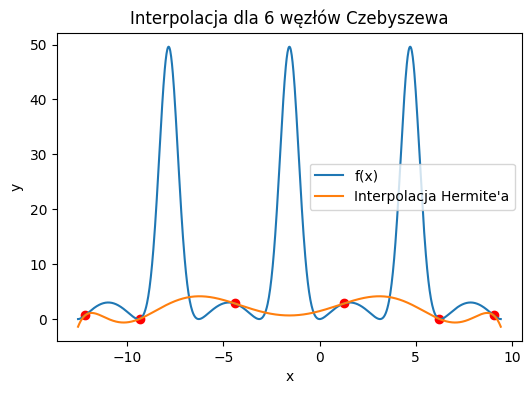

,Interpolacja Hermite'a
Błąd bezwzględny,48.9266913736335
Błąd średniokwadratowy,257.537559109448


In [64]:
n=6
display_interpolation(f,a,b,n, hermite_interpolation_func, label="Interpolacja Hermite'a", title=f"Interpolacja dla "
                                                                                                 f"{n} "
                                                                                                 "węzłów rozłożonych "
                                                                                                 "równomiernie" )
display_interpolation(f,a,b,n, hermite_interpolation_func, label=f"Interpolacja Hermite'a", chebyshev=True,
                      title=f"Interpolacja dla {n} węzłów Czebyszewa" )

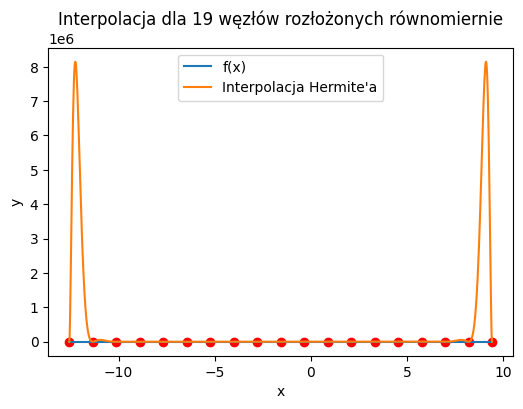

,Interpolacja Hermite'a
Błąd bezwzględny,8145640.86330008
Błąd średniokwadratowy,2149627254024.15


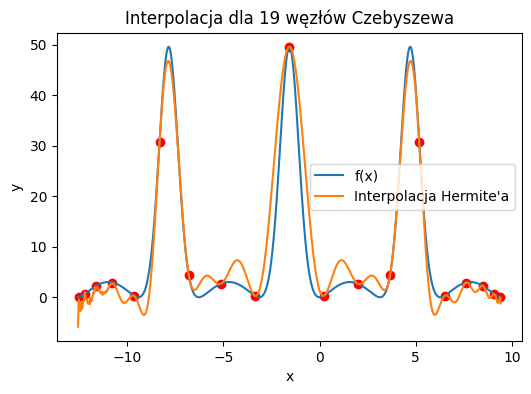

,Interpolacja Hermite'a
Błąd bezwzględny,14.3056821675862
Błąd średniokwadratowy,16.3684147796483


In [32]:
n=19
display_interpolation(f,a,b,n, hermite_interpolation_func, label="Interpolacja Hermite'a", title=f"Interpolacja dla "
                                                                                                 f"{n} "
                                                                                                 "węzłów rozłożonych "
                                                                                                 "równomiernie" )
display_interpolation(f,a,b,n, hermite_interpolation_func, label=f"Interpolacja Hermite'a", chebyshev=True,
                      title=f"Interpolacja dla {n} węzłów Czebyszewa" )

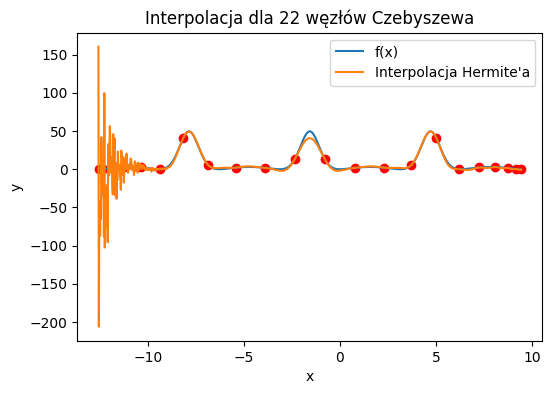

,Interpolacja Hermite'a
Błąd bezwzględny,206.193986023886
Błąd średniokwadratowy,172.146575178120


In [47]:
n=22
# display_interpolation(f,a,b,n, hermite_interpolation_func, label="Interpolacja Hermite'a", title=f"Interpolacja dla "
#                                                                                                  f"{n} "
#                                                                                                  "węzłów rozłożonych "
#                                                                                                  "równomiernie" )
display_interpolation(f,a,b,n, hermite_interpolation_func, label=f"Interpolacja Hermite'a", chebyshev=True,
                      title=f"Interpolacja dla {n} węzłów Czebyszewa" )

##### 2.3.1. Algorytm realizujący szukanie najlepszego wielomianu

In [48]:
def find_best_polynomial(f, n_max, interpolation, chebyshev=False):
    start_time = time()
    xs = np.linspace(a,b, points)
    best_n = 2
    min_mse = float('inf')
    derivate = calc_derivate(f, 1)
    for n in range(2, n_max+1):
        W = interpolation(f, a, b, n, chebyshev=chebyshev, derivate=derivate)
        W_mse = mse(f, W, xs)

        if W_mse < min_mse:
            min_mse = W_mse
            best_n = n
    end_time = time()
    display_time(end_time-start_time)
    return best_n


##### 2.3.2. Najlepszy wielomian dla interpolacji Hermite'a z równomiernym rozkładem punktów

In [52]:
find_best_polynomial(f, 15, hermite_interpolation_func)

Czas trwania algorytmu: 0 godzin 0 minut 15 sekund


4

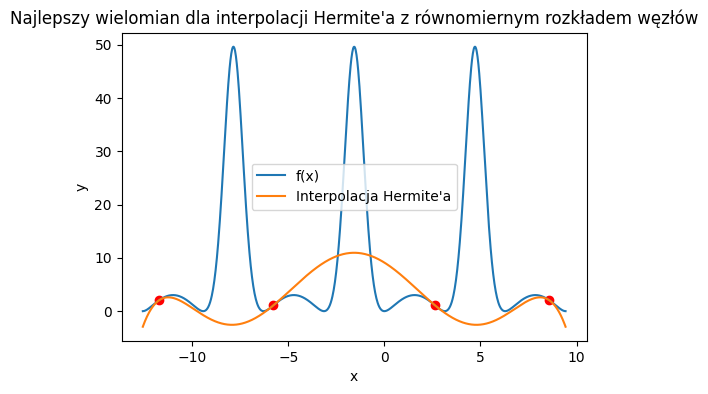

,Interpolacja Hermite'a
Błąd bezwzględny,52.1550135166438
Błąd średniokwadratowy,274.583406145051


In [62]:
n=4
display_interpolation(f,a,b,n, hermite_interpolation_func, label=f"Interpolacja Hermite'a",
                      title=f"Najlepszy wielomian dla interpolacji Hermite'a z równomiernym rozkładem węzłów",
                      chebyshev=True )

##### 2.3.3. Najlepszy wielomian dla interpolacji Hermite'a z węzłami Czebyszewa

In [61]:
find_best_polynomial(f, 30, hermite_interpolation_func, chebyshev=True)

Czas trwania algorytmu: 0 godzin 0 minut 45 sekund


20

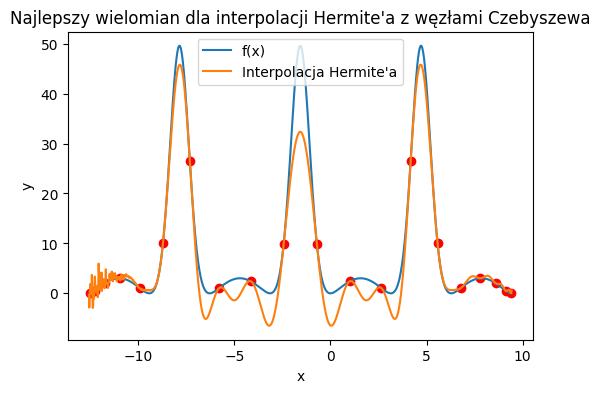

,Interpolacja Hermite'a
Błąd bezwzględny,17.2322612526588
Błąd średniokwadratowy,14.3239393960794


In [63]:
n=20
display_interpolation(f,a,b,n, hermite_interpolation_func, label=f"Interpolacja Hermite'a",
                      title=f"Najlepszy wielomian dla interpolacji Hermite'a z węzłami Czebyszewa", chebyshev=True )